In [ ]:
!pip install tensorflow numpy matplotlib wandb datasets arabic_reshaper python_bidi

In [ ]:
!pip install -U datasets

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import wandb
import os
import re
import keras
from warnings import filterwarnings
from datasets import load_dataset
from PIL import Image
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display
from io import BytesIO
from tensorflow.keras.layers import StringLookup
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.backend import ctc_decode


filterwarnings('ignore')
os.environ.pop("WANDB_X_REQUIRE_LEGACY_SERVICE", None)
plt.rcParams["font.family"] = "DejaVu Sans"

# Start Experiments

## load the data

In [ ]:
dataset = load_dataset("mssqpi/Arabic-OCR-Dataset")
dataset

README.md:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/427M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2160000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 2160000
    })
})

In [ ]:
train = dataset["train"].select(range(200000))
validation= dataset["train"].select(range(200000,210000))
test = dataset["train"].select(range(210000,220000))

## preprocess the data

In [ ]:
def resize_with_padding(img, target_size):
    target_width, target_height = target_size
    original_width, original_height = img.size

    ratio = min(target_width / original_width, target_height / original_height)
    new_size = (int(original_width * ratio), int(original_height * ratio))
    resized = img.resize(new_size, Image.Resampling.LANCZOS)

    padded_img = Image.new('RGB', (target_width, target_height), (255, 255, 255))
    paste_position = ((target_width - new_size[0]) // 2, (target_height - new_size[1]) // 2)
    padded_img.paste(resized, paste_position)

    return padded_img

def preprocess(target_size=(80, 35),normalize=True):
    def process_split(split):
        images = []
        texts = []
        for sample in split:
            img = sample["image"]
            if isinstance(img, dict) and "bytes" in img:
                img = Image.open(BytesIO(img["bytes"]))
            resized_img = resize_with_padding(img, target_size)
            images.append(np.array(resized_img))
            texts.append(sample["text"])

        if normalize:
            return np.array(images), np.array(texts)
        return np.array(images), np.array(texts)

    train_images, train_texts = process_split(train)
    validation_images, validation_texts = process_split(validation)
    test_images, test_texts = process_split(test)

    return (train_images, train_texts), (validation_images, validation_texts), (test_images, test_texts)

In [ ]:
(train_images,train_texts),(validation_images,validation_texts),(test_images,test_texts)=preprocess()

In [ ]:
print("Train image shape:", train_images.shape)

Train image shape: (200000, 35, 80, 3)


In [ ]:
list=[]

all_text = np.concatenate((train_texts,validation_texts,test_texts))


for text in all_text:
    if not text:
        continue

    temp = [ord(char) for char in text]
    list.append(temp)

number_set=set()
for numbers in list:
    for number in numbers:
        number_set.add(number)

print(f"Number char in the data {len(number_set)}")

Number char in the data 37


In [ ]:
max_text=0
for text in all_text:
    max_text = max(max_text, len(text))

print(f"Max text length {max_text}")

Max text length 10


In [ ]:
all_text = np.concatenate((train_texts,validation_texts,test_texts))

char_set=set()

for text in all_text:
    if not text:
        continue
    chars = [char for char in text]

    for char in chars:
        char_set.add(char)
char_set = sorted(char_set)

print(f"The char in vocab {char_set}")

The char in vocab ['ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ـ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي']


## Create a string lookup for convert the string to numbers

In [ ]:
char_to_num = StringLookup(vocabulary=char_set,  mask_token=None )

num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [ ]:
print(f"The vocabulary is {char_to_num.get_vocabulary()}")

The vocabulary is ['[UNK]', np.str_('ء'), np.str_('آ'), np.str_('أ'), np.str_('ؤ'), np.str_('إ'), np.str_('ئ'), np.str_('ا'), np.str_('ب'), np.str_('ة'), np.str_('ت'), np.str_('ث'), np.str_('ج'), np.str_('ح'), np.str_('خ'), np.str_('د'), np.str_('ذ'), np.str_('ر'), np.str_('ز'), np.str_('س'), np.str_('ش'), np.str_('ص'), np.str_('ض'), np.str_('ط'), np.str_('ظ'), np.str_('ع'), np.str_('غ'), np.str_('ـ'), np.str_('ف'), np.str_('ق'), np.str_('ك'), np.str_('ل'), np.str_('م'), np.str_('ن'), np.str_('ه'), np.str_('و'), np.str_('ى'), np.str_('ي')]


## Convert the data to tenserflow dataset

In [ ]:
def encode_data(image, label):
    img = tf.convert_to_tensor(image)

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}

In [ ]:
def prepare_dataset(images,texts,padded_batch=16):
    data = tf.data.Dataset.from_tensor_slices((images, texts))
    data = (data.map(encode_data, num_parallel_calls=tf.data.AUTOTUNE)
                                  .padded_batch(padded_batch)
                                  .prefetch(buffer_size=tf.data.AUTOTUNE))
    return data

In [ ]:
train_dataset = prepare_dataset(train_images, train_texts,16)
validation_dataset = prepare_dataset(validation_images, validation_texts,16)
test_dataset = prepare_dataset(test_images, test_texts,16)

## Implementation ctc layer
This is a custom Keras layer that implements the Connectionist Temporal Classification (CTC) loss function, commonly used for sequence learning tasks like speech recognition or handwriting recognition.

In [ ]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        """
        Defines the forward pass of the layer where the computation happens
        :param y_true: ground truth labels
        :param y_pred: model predictions
        :return: Returns the predictions unchanged
        """

        # Gets the batch size (number of samples in the batch) from y_true and converts it to int64.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

        # Gets the sequence length of the predictions (second dimension of y_pred) and converts to int64.
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")

        # Gets the sequence length of the labels (second dimension of y_true) and converts to int64.
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        # Creates a tensor of shape (batch_size, 1) where each element is the input sequence length.
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        # Creates a tensor of shape (batch_size, 1) where each element is the label sequence length.
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred



## Build the model use ResNet50 base model

In [ ]:
def build_model():
    imgs = tf.keras.layers.Input(shape=(35, 80, 3), name="image", dtype="float32")
    labels = tf.keras.layers.Input(name="label", shape=(None,), dtype="float32")

    x = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same", name="Conv1")(imgs)
    x = tf.keras.layers.BatchNormalization(name="BatchNormalization1")(x)
    x = tf.keras.layers.MaxPooling2D((2,2), name="pool1")(x)

    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same", name="Conv2")(x)
    x = tf.keras.layers.BatchNormalization(name="BatchNormalization2")(x)
    x = tf.keras.layers.MaxPooling2D((2,2), name="pool2")(x)

    new_shape = (x.shape[2], x.shape[1] * x.shape[3])
    x = tf.keras.layers.Reshape(new_shape, name="reshape")(x)

    x = tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = tf.keras.layers.BatchNormalization(name="BatchNormalization3")(x)
    x = tf.keras.layers.Dropout(0.5, name="dropout1")(x)

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)

    x = tf.keras.layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax",name="dense2")(x)

    output = CTCLayer(name="ctc_loss")(labels, x)
    model = tf.keras.models.Model(inputs=[imgs, labels], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,clipvalue=1.0))

    return model

model=build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 35, 80, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 35, 80,    │        896 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization1 │ (None, 35, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 17, 40,    │          0 │ BatchNormalizati… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 17, 40,    │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization2 │ (None, 17, 40,    │        256 │ Conv2[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 8, 20, 64) │          0 │ BatchNormalizati… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 20, 512)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 20, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization3 │ (None, 20, 64)    │        256 │ dense1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 20, 64)    │          0 │ BatchNormalizati… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 20, 256)   │    197,632 │ dropout1[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 20, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 20, 39)    │      5,031 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 20, 39)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 419,879 (1.60 MB)

 Trainable params: 419,559 (1.60 MB)

 Non-trainable params: 320 (1.25 KB)

## Build a edit distance calculate

In [ ]:
test_images = []
test_labels = []

for batch in test_dataset:
    test_images.append(batch["image"])
    test_labels.append(batch["label"])

In [ ]:
def calculate_edit_distance(labels, predictions):
    saprse_labels = tf.sparse.from_dense(labels)

    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]

    predictions_decoded = tf.keras.backend.ctc_decode(

        predictions, input_length=input_len, greedy=False, beam_width=100)[0][0]
    sparse_predictions =tf.sparse.from_dense(predictions_decoded)

    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceMetrics:
    def __init__(self, prediction_model):
        self.prediction_model = prediction_model
        self.edit_distances = []

    def evaluate(self, images, labels):
        for i in range(len(images)):
            label = labels[i]
            prediction = self.prediction_model.predict(images[i])
            edit_distance = calculate_edit_distance(label, prediction).numpy()
            self.edit_distances.append(edit_distance)

        average_edit_distance = np.mean(self.edit_distances)
        return average_edit_distance

## Build BatchLossLogger to save loss by step


In [ ]:
class BatchLossLogger(Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

## Train thee model

In [ ]:
epochs = 10
early_stopping_patience = 2

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=early_stopping_patience,
    restore_best_weights=True
)

batch_loss_logger = BatchLossLogger()

In [ ]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[batch_loss_logger, early_stopping])

Epoch 1/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 364s 28ms/step - loss: 349.9637 - val_loss: 241.3702
Epoch 2/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 329s 26ms/step - loss: 231.5504 - val_loss: 167.9081
Epoch 3/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 322s 26ms/step - loss: 172.3433 - val_loss: 119.8633
Epoch 4/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 339s 27ms/step - loss: 130.8296 - val_loss: 91.4417
Epoch 5/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 332s 27ms/step - loss: 102.1012 - val_loss: 75.6843
Epoch 6/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 318s 25ms/step - loss: 82.8976 - val_loss: 62.0643
Epoch 7/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 329s 26ms/step - loss: 69.8424 - val_loss: 49.3096
Epoch 8/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 347s 28ms/step - loss: 60.1839 - val_loss: 42.9294
Epoch 9/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 332s 27ms/step - loss: 53.1149 - val_loss: 38.0041
Epoch 10/10
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 337s 27ms/step - loss: 47.6609 - val_loss: 35.2997


In [ ]:
model.save("arabic_img2md_advance_ocr.h5")

## Visualize the loss plot

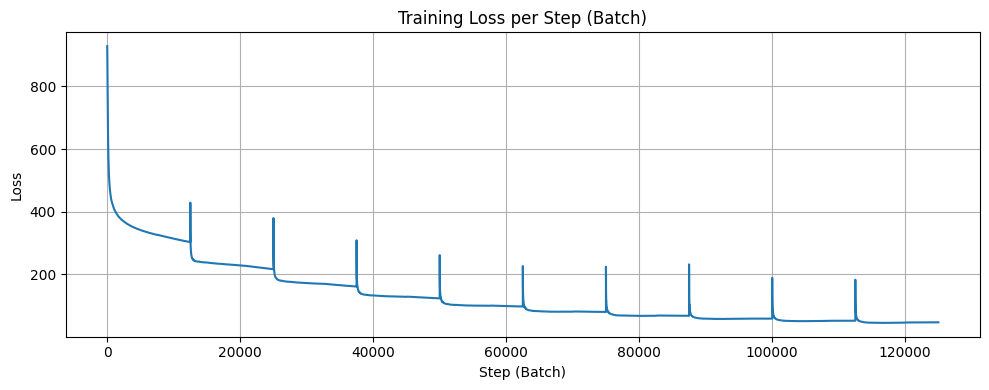

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(batch_loss_logger.batch_losses)
plt.title("Training Loss per Step (Batch)")
plt.xlabel("Step (Batch)")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

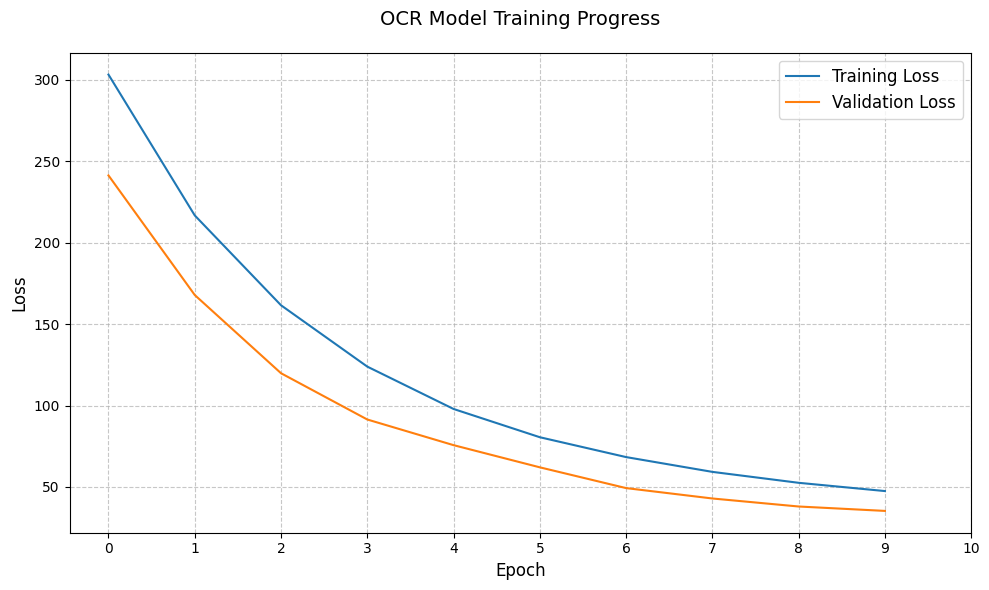

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title("OCR Model Training Progress", fontsize=14, pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

max_epoch = len(history.history['loss'])
plt.xticks(range(0, max_epoch+1, max(1, max_epoch//10)))

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Inference

In [ ]:
prediction_model = keras.models.Model(
    inputs=model.inputs[0],
    outputs=model.get_layer("dense2").output
)

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res.replace("[UNK]", ""))

    return output_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


(np.float64(-0.5), np.float64(79.5), np.float64(34.5), np.float64(-0.5))

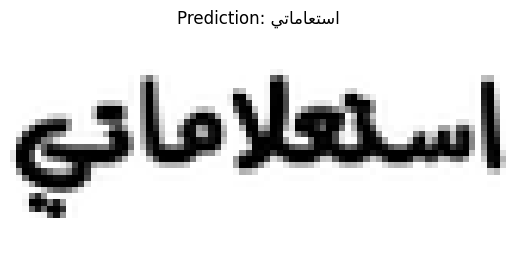

In [ ]:
image = test_images[300][15]
preds = prediction_model.predict(tf.convert_to_tensor([image]))
pred_texts = decode_batch_predictions(preds)

pred_text = pred_texts[0]

pred_text = arabic_reshaper.reshape(pred_text)
pred_text = get_display(pred_text)

plt.imshow(image)
plt.title(f"Prediction: {pred_text}")
plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
['الصيفومن', 'ومشتاقا', 'كالأمين', 'لينماسيوم', 'وراينلاند', 'اسطبولس', 'التوبلي', 'اذدسهارا', 'الحلماوات', 'انولاتا', 'الأسباخ', 'البارباء', 'خخـلفـه', 'بالطحانة', 'يعتبرون', 'الفردوسية']


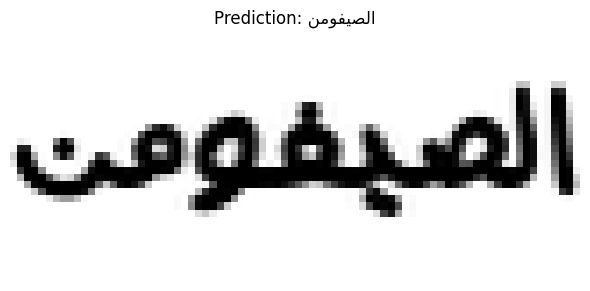

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
['متضمنها', 'تنحيفها', 'الأسراى', 'أستيقاط', 'هوساوية', 'توميلتجول', 'الوراني', 'ألوصورين', 'أنطونيتا', 'وبالقانون', 'بروجكتس', 'السريره', 'أفروختن', 'عاطفتين', 'استنائي', 'لوتشيضع']


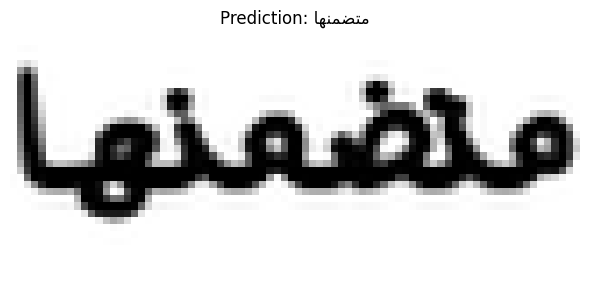

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
['ولودويك', 'الغيبون', 'البرهوني', 'والمهابط', 'الاشنئيش', 'هاريدوار', 'الصامتو', 'المفاخرة', 'بالإعتزال', 'مقايضتهم', 'المخبات', 'بشهاداتنا', 'يظهرأكحينا', 'البيسفنينول', 'وكاليماث', 'المأمومة']


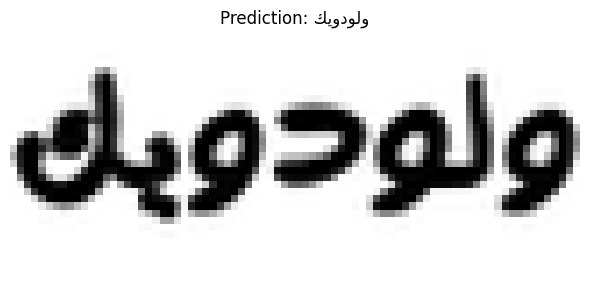

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
['والمطوبات', 'وأورهان', 'فموازنة', 'وتمليتها', 'المجهريه', 'ادهمارات', 'لبرفسور', 'معتقدنا', 'وليتعاون', 'أوفدتها', 'أنجيوليني', 'وأدريانا', 'لمتهني', 'مجامعها', 'الديتومات', 'ومنفذين']


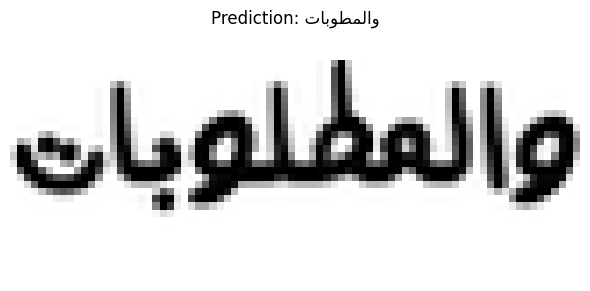

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
['لاسكتلند', 'بوستوكوس', 'وأعدمتهم', 'الاعفان', 'فيلتقون', 'الصريحي', 'وبالغرم', 'بالمعرفه', 'بالونيين', 'يسلوفتش', 'بتعيده', 'الجازومن', 'فاغتنمت', 'الإغوانة', 'كالأخيف', 'أيفاوتكون']


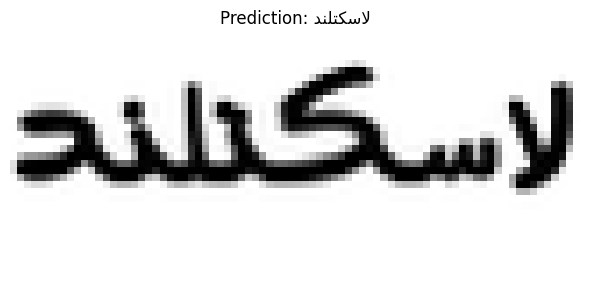

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
['الطافيه', 'الإيثير', 'المسندات', 'مكونانسي', 'كمايعرف', 'ارزنيستو', 'للودفيش', 'أخروكما', 'فيمديرية', 'والسرداب', 'الزانات', 'للعيساوي', 'للاخطوط', 'أحمديوره', 'بالحشوات', 'هحخةشكار']


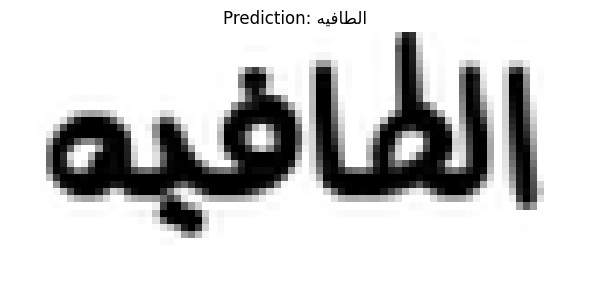

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
['وللخرافة', 'الواحديين', 'بيليابورزا', 'ليفينلي', 'الخرسان', 'الطميحي', 'لبيلاميرا', 'التناطرى', 'ازوجتهود', 'الكومبو', 'زيزيزينه', 'اباتينات', 'الخريف', 'فالحنفية', 'أنجيولني', 'بامبلبي']


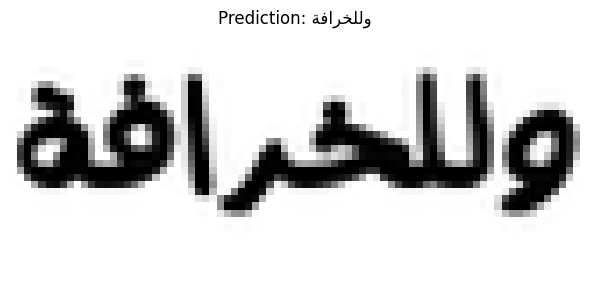

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
['ييبلغه', 'التجهيل', 'انابينا', 'بونيس', 'واستيعابهم', 'والسلقية', 'الأنمي', 'الجرموق', 'سينايكا', 'أعدمتهم', 'دياتوما', 'ونوكوب', 'اليعضيد', 'والنفاد', 'الاقتبالات', 'وأناقتها']


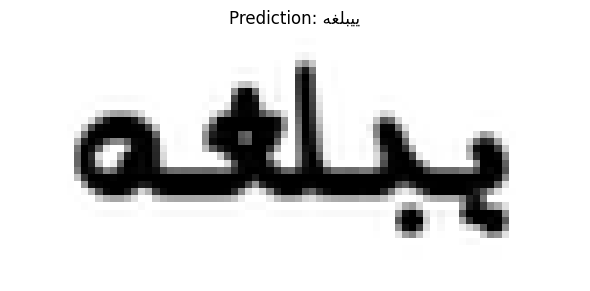

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
['منشارية', 'ديرسروزا', 'أولوباتلي', 'أكواتلون', 'البجادي', 'كانالدا', 'كيرباتشي', 'والبردتقوش', 'البوجلينا', 'بالجناية', 'محمدعال', 'وحسناتك', 'للادوار', 'وتوعيته', 'كاهتمام', 'بأنتشطام']


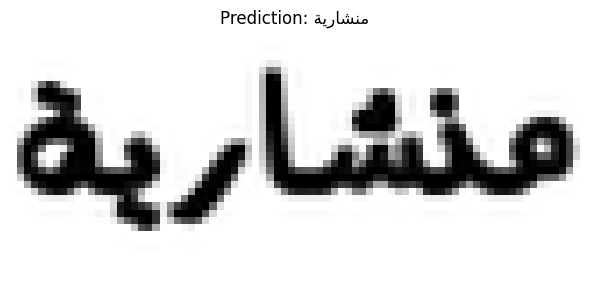

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
['والحوجاج', 'للمعرفه', 'فاجئتها', 'واتحهمأات', 'والقاعديه', 'الساقطه', 'احتانا', 'الإغواندون', 'عريفارسي', 'الصضيةوهي', 'كالاسجناء', 'اليستريتد', 'للبجادي', 'مستلطف', 'تباشيره', 'هندباوية']


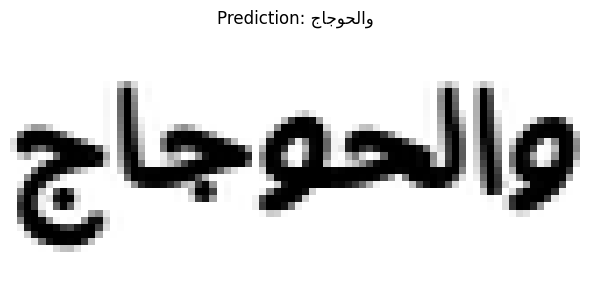

In [ ]:
for batch in test_dataset.take(10):
    batch_images = batch["image"]
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)
    img = batch_images[0]
    pred_text = pred_texts[0]

    pred_text = pred_texts[0]

    pred_text = arabic_reshaper.reshape(pred_text)
    pred_text = get_display(pred_text)

    if len(img.shape) == 3:
        img = (img).numpy()
        img = img[:, :, 0]
    elif len(img.shape) == 2:
        img = (img * 255.0).numpy()

    plt.figure(figsize=(6, 4))
    plt.imshow(img, cmap="gray")
    plt.title(f"Prediction: {pred_text}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

